In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

dftrain = pd.read_csv(r"archive\Train_data.csv")
dftest = pd.read_csv(r"archive\Test_data.csv")
print(dftrain.isnull().sum())
print(dftest.isnull().sum())
print(dftrain.shape , dftest.shape)       
print(dftrain.head() , dftest.head())        
print(dftrain['class'].value_counts())  


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [2]:
#print cols with strings as elements both in train and test
for col in dftrain.columns.intersection(dftest.columns):
    if dftrain[col].dtype == 'object' and dftest[col].dtype == 'object':
        print(col)
        categorical_cols=[col]
#count unique elements under the strign columns
for col in categorical_cols:
    print(col, "has", dftrain[col].nunique(), "unique categories")

print(dftrain.shape , dftest.shape) 
print(dftrain['service'])         # preview



protocol_type
service
flag
flag has 11 unique categories
(25192, 42) (22544, 41)
0        ftp_data
1           other
2         private
3            http
4            http
           ...   
25187        exec
25188    ftp_data
25189     private
25190        nnsp
25191      finger
Name: service, Length: 25192, dtype: object


In [3]:
x_train = dftrain.drop('class', axis=1)
y_train = dftrain['class'].map({'normal':0, 'anomaly':1})
x_test= dftest

x_val_train, x_val_test, y_val_train, y_val_test=train_test_split( x_train, y_train, test_size=0.2, random_state=42)

#label encoder
# categorical_cols = ['protocol_type', 'service', 'flag']
# for col in categorical_cols:
#     le = LabelEncoder()
#     combined = pd.concat([dftrain[col], dftest[col]], axis=0)
#     le.fit(combined)
#     dftrain[col] = le.transform(dftrain[col])
#     dftest[col] = le.transform(dftest[col])

one_hot_cols=['protocol_type' , 'flag']
target_cols=['service']

#target encoding the large data
te = TargetEncoder(cols=target_cols)
x_val_train=te.fit_transform(x_val_train, y_val_train)  
x_val_test=te.transform(x_val_test)                   
x_test=te.transform(x_test)                

#one hot encoding smaller data
combined=pd.concat([x_val_train, x_val_test, x_test], axis=0)

combined=pd.get_dummies(combined, columns=one_hot_cols)

# Split back into train, val, test
x_val_train=combined.iloc[:len(x_val_train), :]
x_val_test=combined.iloc[len(x_val_train):len(x_val_train)+len(x_val_test), :]
x_test=combined.iloc[len(x_val_train)+len(x_val_test):, :]

print(x_val_train.head())
print(x_val_train.columns)

       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
2199          0  0.903138          8          0     0               0       0   
15288         0  0.954664          0          0     0               0       0   
4139          0  0.386397      16787          0     0               0       0   
3505          0  0.954664          0          0     0               0       0   
19281         0  0.999946          0          0     0               0       0   

       hot  num_failed_logins  logged_in  ...  flag_REJ  flag_RSTO  \
2199     0                  0          0  ...     False      False   
15288    0                  0          0  ...     False      False   
4139     0                  0          0  ...     False      False   
3505     0                  0          0  ...     False      False   
19281    0                  0          0  ...     False      False   

       flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
2199         F

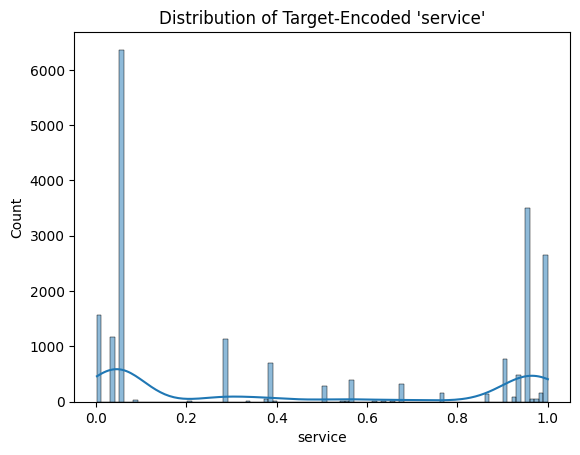

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(x_val_train['service'], bins=100, kde=True)
plt.title("Distribution of Target-Encoded 'service'")
plt.show()

Majority of Services almost always relate to normal or abnormal traffic

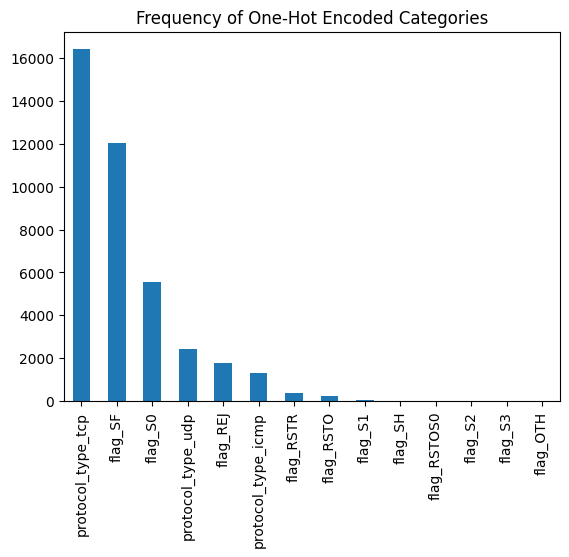

In [5]:
one_hot_cols_new=[col for col in x_val_train.columns if 'protocol_type' in col or 'flag' in col]
x_val_train[one_hot_cols_new].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Frequency of One-Hot Encoded Categories")
plt.show()

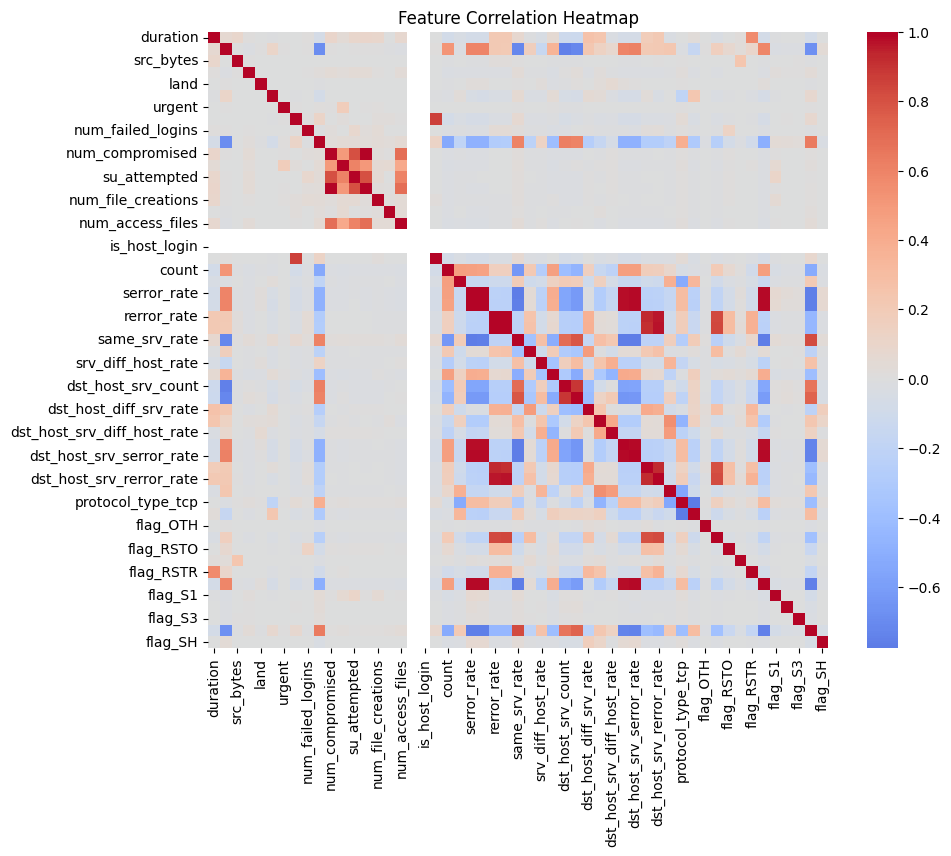

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(x_val_train.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [7]:
constant_cols_val_train = [col for col in x_val_train.columns if x_val_train[col].nunique() == 1]
constant_cols_val_test = [col for col in x_val_test.columns if x_val_test[col].nunique() == 1]
constant_cols_test = [col for col in x_test.columns if x_test[col].nunique() == 1]
print(constant_cols_val_train,constant_cols_val_test ,constant_cols_test)
# Drop 
x_val_train=x_val_train.drop(columns=constant_cols_val_train)
x_val_test= x_val_test.drop(columns=constant_cols_val_train, errors='ignore')
x_test= x_test.drop(columns=constant_cols_val_train, errors='ignore')



['num_outbound_cmds', 'is_host_login'] ['land', 'urgent', 'num_outbound_cmds', 'is_host_login', 'flag_OTH'] ['num_outbound_cmds']


In [8]:
x_val_train=x_val_train.astype(float)
x_val_test=x_val_test.astype(float)
x_test=x_test.astype(float)

print(x_val_train.head())
print(x_val_train.columns)

scaler=StandardScaler()
x_val_train_scaled = scaler.fit_transform(x_val_train)
x_val__test_scaled = scaler.transform(x_val_test)
x_test_scaled = scaler.transform(x_test)



       duration   service  src_bytes  dst_bytes  land  wrong_fragment  urgent  \
2199        0.0  0.903138        8.0        0.0   0.0             0.0     0.0   
15288       0.0  0.954664        0.0        0.0   0.0             0.0     0.0   
4139        0.0  0.386397    16787.0        0.0   0.0             0.0     0.0   
3505        0.0  0.954664        0.0        0.0   0.0             0.0     0.0   
19281       0.0  0.999946        0.0        0.0   0.0             0.0     0.0   

       hot  num_failed_logins  logged_in  ...  flag_REJ  flag_RSTO  \
2199   0.0                0.0        0.0  ...       0.0        0.0   
15288  0.0                0.0        0.0  ...       0.0        0.0   
4139   0.0                0.0        0.0  ...       0.0        0.0   
3505   0.0                0.0        0.0  ...       0.0        0.0   
19281  0.0                0.0        0.0  ...       0.0        0.0   

       flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  flag_SF  \
2199          

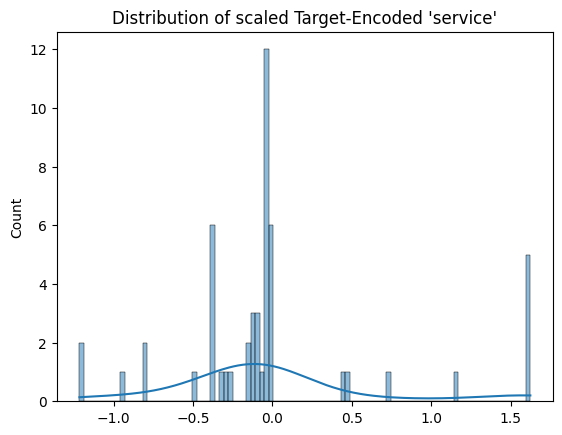

In [9]:
sns.histplot(x_val_train_scaled[1], bins=100, kde=True)
plt.title("Distribution of scaled Target-Encoded 'service'")
plt.show()

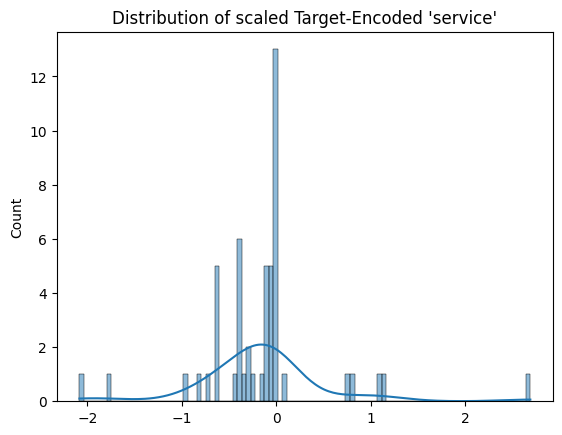

In [10]:
sns.histplot(x_val_train_scaled[49], bins=100, kde=True)
plt.title("Distribution of scaled Target-Encoded 'service'")
plt.show()